Here we seek to solve
\begin{align}
\min_{(u,\rho)\in\mathcal{V}\times\mathcal{M}}J(u,\rho)&:=\frac{1}{2}\int_{\Omega}(u-u_{d})^{2}\mathrm{d}V+\frac{1}{2}R(\rho)\\
R(\rho)&:=\int_{\Omega}(\gamma_{1}\,\rho^{2}+\gamma_{2}\nabla \rho\cdot\nabla \rho)\mathrm{d}V
\end{align}

subject to the partial differential equality constraint

\begin{align*}
-\nabla\cdot\left(\rho\,\nabla u\right)+\beta\, u&=f,\,\,\,\text{ in }\Omega \\
\frac{\partial u}{\partial n}&=0,\,\,\,\text{ on }\partial\Omega
\end{align*}

and bound constraint

\begin{align*}
\rho(x)\geq \rho_{\ell}(x)>0,\,\,\,\text{ on }\overline{\Omega}
\end{align*}

here $\beta\in\mathbb{R}$, $f:\Omega\rightarrow\mathbb{R}$, $u_{d}:\Omega\rightarrow\mathbb{R}$, $\rho_{\ell}:\overline{\Omega}\rightarrow\mathbb{R}_{>0}$, $\lbrace \gamma_{j}\rbrace_{j=1}^{2}\subset\mathbb{R}_{\geq 0}$ are given.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import dolfin as dl
# False - natural ordering; True - interlace
dl.parameters['reorder_dofs_serial'] = False


from filterLineSearchSuper import interior_pt
from hippylib import nb

from problems import inverseDiffusion

from helperfunctions import grad_check

In [2]:
plt.style.use('classic')
plt.rcParams.update({'font.size': 16})

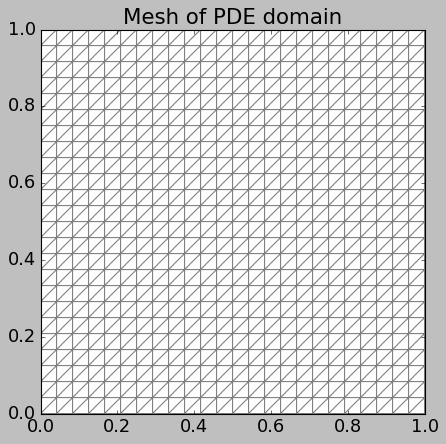

In [3]:
nx = 24 

# coarse and fine meshes
mesh = dl.UnitSquareMesh(nx, nx)

dl.plot(mesh)
plt.title('Mesh of PDE domain')
plt.show()

In [4]:
P1_deg = 1 # degree of finite-element polynomials for parameter (rho)
P2_deg = 2 # degree of finite-element polynomials for state

P1 = dl.FiniteElement("CG", mesh.ufl_cell(), P1_deg)
P2 = dl.FiniteElement("CG", mesh.ufl_cell(), P2_deg)
Th = dl.MixedElement([P2, P1])
Vh = dl.FunctionSpace(mesh, Th)
Vh1 = dl.FunctionSpace(mesh, P1)
Vh2 = dl.FunctionSpace(mesh, P2)

print("dim(state) = {0:d}, dim(parameter) = {1:d}".format(Vh.sub(0).dim(), Vh.sub(1).dim()))

dim(state) = 2401, dim(parameter) = 625


In [5]:
beta   = 1.
gamma1 = 1.e-4
gamma2 = 1.e-4
Crhol  = 0.75


rhol = dl.interpolate(dl.Expression('C', element=Vh1.ufl_element(), C=Crhol), Vh1).vector()[:]
         
ud   = dl.interpolate(dl.Expression('std::cos(x[0]*pi)*std::cos(x[1]*pi)',\
                                          pi=np.pi, element=Vh2.ufl_element()), Vh2)
g    = dl.interpolate(dl.Expression('(2.*pi*pi*(0.5+x[0]) + beta)*std::cos(x[0]*pi)*std::cos(x[1]*pi)'+\
                                          '+pi*std::sin(pi*x[0])*std::cos(pi*x[1])',\
                                           pi=np.pi, beta=beta, element=Vh2.ufl_element()), Vh2)

problem = inverseDiffusion(Vh, Vh1, Vh2, beta, gamma1, gamma2, ud, g, rhol)

rhotrue = dl.interpolate(dl.Expression('0.5+x[0]',\
                                      element=Vh1.ufl_element()), Vh1)
    


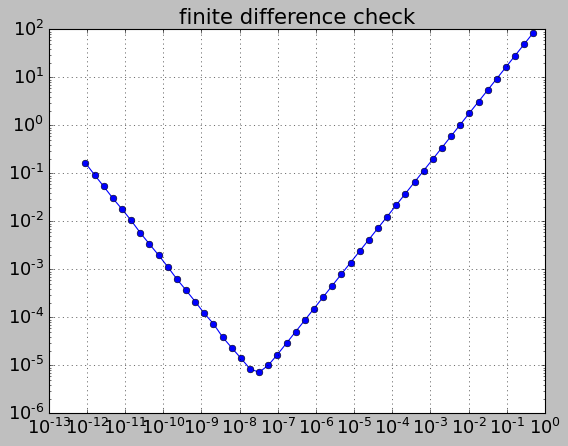

In [6]:
# ---- gradient check

def grad_check(F, gradF, x0, xhat):
    epss = np.logspace(1, 40, base=0.5)
    F0   = F(x0)
    gradF0   = gradF(x0)
    grad_err = np.zeros(len(epss))
    for j, eps in enumerate(epss):
        Fplus = F(x0 + eps*xhat)
        if len(gradF0.shape) > 1:
            grad_err[j] = np.linalg.norm((Fplus - F0)/ eps - gradF0.dot(xhat), 2)
        else:
            grad_err[j] = np.abs((Fplus - F0) / eps - np.inner(gradF0, xhat))
    plt.plot(epss, grad_err, '-ob')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    plt.title('finite difference check')
    plt.show()

    
    
F     = lambda x : problem.c(x)
gradF = lambda x : problem.Dxc(x)

# initial point
x0 = np.array([1.+np.random.randn() if i < Vh2.dim() \
      else (abs(np.random.randn())+1. + rhol[i-Vh2.dim()]) for i in range(Vh.dim())])
xhat = np.random.randn(Vh.dim()) 


grad_check(F, gradF, x0, xhat)

In [7]:
solver = interior_pt(problem, linsolve_strategy="direct")
x0      = np.ones(problem.n)
x0[:problem.n1] = problem.restore_feasibility(x0)
X0      = [x0, np.ones(problem.m), np.ones(problem.n2)]
solver.initialize(X0)
mu0 = 1.e0
tol = 1.e-10
max_it = 25
Xf, mu, E, Mus = solver.solve(tol, max_it, mu0)
xf, lamf, zf = Xf[:]

-------------------------------------------------- it = 0
solved barrier problem (mu = 1.000e+00)
solved barrier problem (mu = 5.000e-01)
solved barrier problem (mu = 2.500e-01)
solved barrier problem (mu = 1.250e-01)
-------------------------------------------------- determining search direction 
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 9.555e-01
in filter region?  False
A.5.4
theta(x) = 9.04e-14
angle between xhat and Dxphi = 135.4 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE I
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 1
solved barrier problem (mu = 4.419e-02)
solved barrier problem (mu = 9.291e-03)
-------------------------------------------------- determining search direction 
NO INERTIA CORRECTION WAS REQUIRED
alpha = 1.000e+00, alphaz = 9.925e-01
in filter region?  False
A.5.4
theta(x) = 4.57e-04
angle between xhat and Dxphi = 140.2 (deg

in filter region?  False
A.5.4
theta(x) = 3.38e-06
angle between xhat and Dxphi = 90.1 (degrees)
descent direction?  True
theta(x) < theta_min?  True
A.5.5
theta(xtrial) = 3.19e-06, theta(x) = 3.38e-06
A-5.10
in filter region?  False
A.5.4
theta(x) = 3.38e-06
angle between xhat and Dxphi = 90.1 (degrees)
descent direction?  True
theta(x) < theta_min?  True
A.5.5
theta(xtrial) = 3.29e-06, theta(x) = 3.38e-06
A-5.10
in filter region?  False
A.5.4
theta(x) = 3.38e-06
angle between xhat and Dxphi = 90.1 (degrees)
descent direction?  True
theta(x) < theta_min?  True
A.5.5
theta(xtrial) = 3.34e-06, theta(x) = 3.38e-06
A-5.10
in filter region?  False
A.5.4
theta(x) = 3.38e-06
angle between xhat and Dxphi = 90.1 (degrees)
descent direction?  True
theta(x) < theta_min?  True
step accepted A-5.4 CASE II
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 17
-------------------------------------------------- determining search 

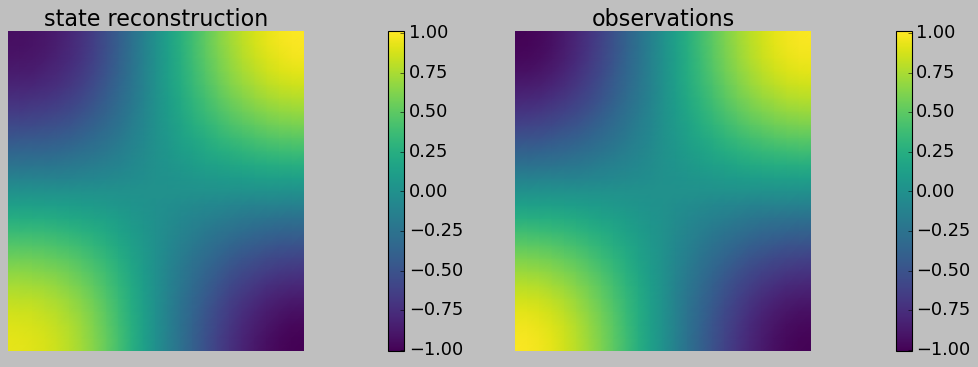

In [8]:
uReconstruction   = dl.Function(Vh2)
lamReconstruction = dl.Function(Vh2)

rhoReconstruction = dl.Function(Vh1)
zReconstruction   = dl.Function(Vh1)

uReconstruction.vector()[:]   = xf[:problem.n1]
rhoReconstruction.vector()[:] = xf[problem.n1:]

lamReconstruction.vector()[:] = lamf[:]
zReconstruction.vector()[:]   = zf[:]

nb.multi1_plot([uReconstruction, ud], ["state reconstruction", "observations"])
plt.show()

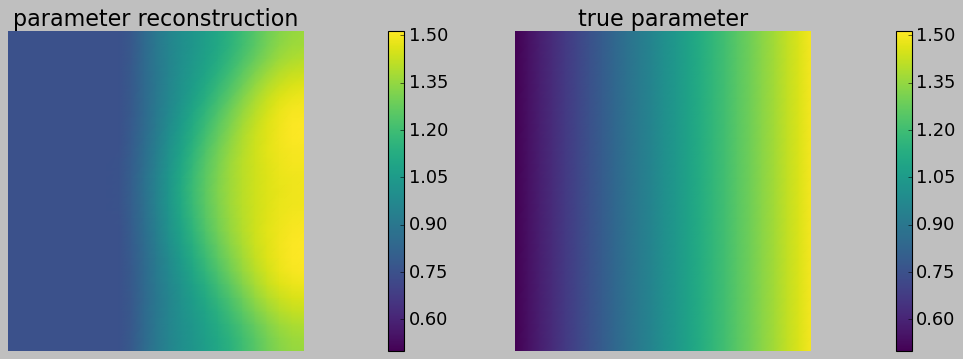

In [9]:
nb.multi1_plot([rhoReconstruction, rhotrue], ["parameter reconstruction", "true parameter"])
plt.show()

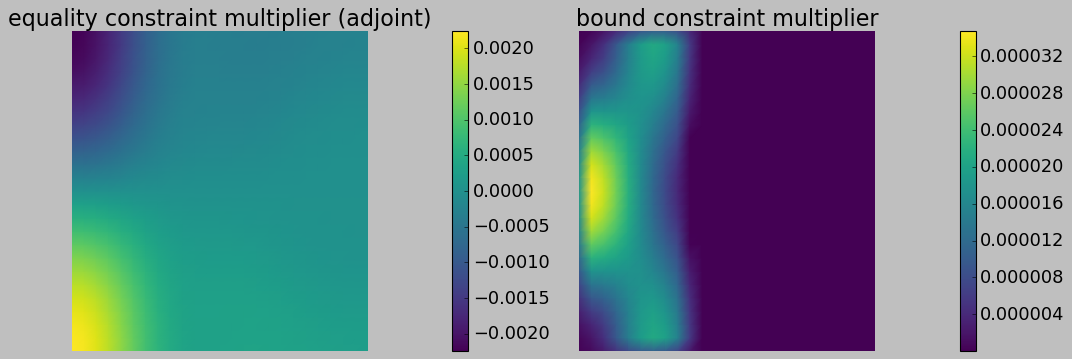

1.31e-11 <= z <= 3.48e-05
portion of bound constraint dofs below tol = 0.53


In [10]:
nb.multi1_plot([lamReconstruction, zReconstruction], \
            ["equality constraint multiplier (adjoint)", "bound constraint multiplier"],\
            same_colorbar=False)
plt.show()

print("{0:1.2e} <= z <= {1:1.2e}".format(min(zf), max(zf)))
print("portion of bound constraint dofs below tol = {0:1.2f}".format(sum(zf < tol)/len(zf)))

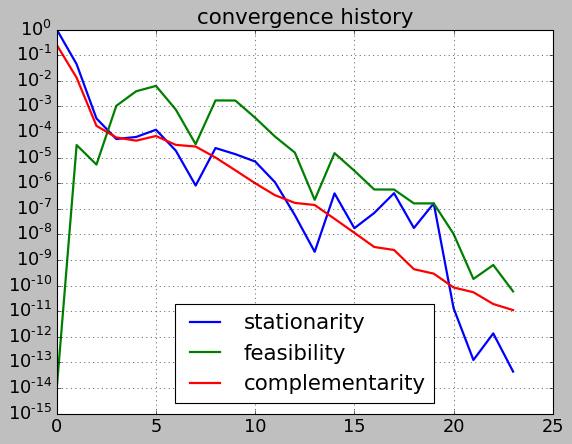

In [11]:
Es = [[E[i][j] for i in range(len(E))] for j in range(len(E[0]))]
labels = ["optimality error", "stationarity", "feasibility", "complementarity"]

for i in range(1,4):
    plt.plot(Es[i], label=labels[i], linewidth=2.0)
    plt.yscale('log')
plt.legend(loc='lower center')
plt.grid()
plt.title('convergence history')
plt.show()